### Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import preprocessing

### Exploratory Data Analysis

In [3]:
delivery_data = pd.read_csv("parcel_delivery_dataset.csv")

delivery_data.head()

,parcel_id,shipment_date,is_weekend,hour,distance_km,parcel_size,parcel_weight_kg,traffic_level,weather_condition,delivery_time_window
0,1,2024-04-17,0,14,38.079472,small,3.330077,low,foggy,afternoon
1,2,2024-07-07,1,14,95.120716,medium,0.675873,low,rainy,afternoon
2,3,2024-03-27,0,14,73.467400,medium,45.398848,high,sunny,evening
3,4,2024-04-29,0,14,60.267190,medium,28.637023,low,sunny,evening
4,5,2024-06-06,0,9,16.445845,small,9.344217,high,snowy,evening


In [4]:
delivery_data.dtypes

parcel_id                 int64
shipment_date            object
is_weekend                int64
hour                      int64
distance_km             float64
parcel_size              object
parcel_weight_kg        float64
traffic_level            object
weather_condition        object
delivery_time_window     object
dtype: object

In [5]:
duplicate_rows = delivery_data[delivery_data.duplicated()]

print(f"There are {duplicate_rows.shape[0]} duplicate rows.")

There are 0 duplicate rows.


In [6]:
rows_with_nulls = delivery_data.isnull().sum()
print(rows_with_nulls)

parcel_id               0
shipment_date           0
is_weekend              0
hour                    0
distance_km             0
parcel_size             0
parcel_weight_kg        0
traffic_level           0
weather_condition       0
delivery_time_window    0
dtype: int64


So there are no duplicate rows in the dataset and no rows containing any NaN or Null values.

In [7]:
delivery_data.head()

,parcel_id,shipment_date,is_weekend,hour,distance_km,parcel_size,parcel_weight_kg,traffic_level,weather_condition,delivery_time_window
0,1,2024-04-17,0,14,38.079472,small,3.330077,low,foggy,afternoon
1,2,2024-07-07,1,14,95.120716,medium,0.675873,low,rainy,afternoon
2,3,2024-03-27,0,14,73.467400,medium,45.398848,high,sunny,evening
3,4,2024-04-29,0,14,60.267190,medium,28.637023,low,sunny,evening
4,5,2024-06-06,0,9,16.445845,small,9.344217,high,snowy,evening


In [8]:
delivery_data.nunique()

parcel_id               50000
shipment_date             366
is_weekend                  2
hour                       17
distance_km             50000
parcel_size                 3
parcel_weight_kg        50000
traffic_level               3
weather_condition           4
delivery_time_window        3
dtype: int64

There are exactly the amount of values for the object dtype columns as you would expect (3, 3, 4 and 3), meaning there are no misspellings of categories. 

In [9]:
delivery_data = delivery_data.drop(['parcel_id'], axis = 1)

delivery_data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_weekend,50000.0,0.284080,0.450980,0.000000,0.000000,0.000000,1.000000,1.000000
hour,50000.0,12.587480,4.069275,6.000000,9.000000,14.000000,14.000000,22.000000
distance_km,50000.0,50.387477,28.552232,1.000548,25.642078,50.390299,75.081838,99.997243
parcel_weight_kg,50000.0,25.210404,14.273970,0.500780,12.798958,25.230957,37.450028,49.996822


Remove parcel_id, as I assume it has no predictive power for the delivery window.

In [10]:
def get_season(date):
  m = date.month
  x = m%12 // 3 + 1
  if x == 1:
    season = "Winter"
  if x == 2:
    season = "Spring"
  if x == 3:
    season = "Summer"
  if x == 4:
    season = "Autumn"
  return season

delivery_data.insert(len(delivery_data.columns)-1, 'season', pd.to_datetime(delivery_data['shipment_date'], format = '%Y-%m-%d'))

delivery_data['season'] = delivery_data['season'].apply(get_season)

delivery_data = delivery_data.drop(['shipment_date'], axis = 1)


Create a new column called 'season' from the shipment_date column. Season could be a good feature to predict the delivery_time_window.

In [11]:
cat_cols=delivery_data.select_dtypes(include=['object']).columns
num_cols = delivery_data.select_dtypes(include=np.number).columns.tolist()

delivery_data_arr = delivery_data.values

is_weekend
Skew : 0.96


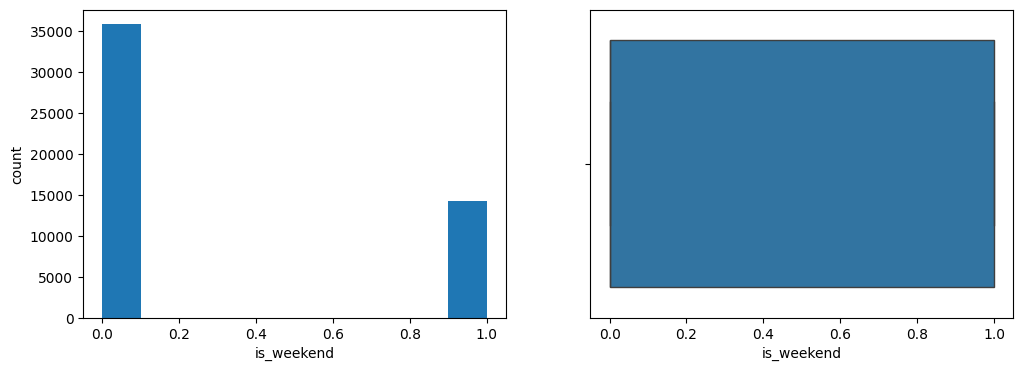

hour
Skew : 0.66


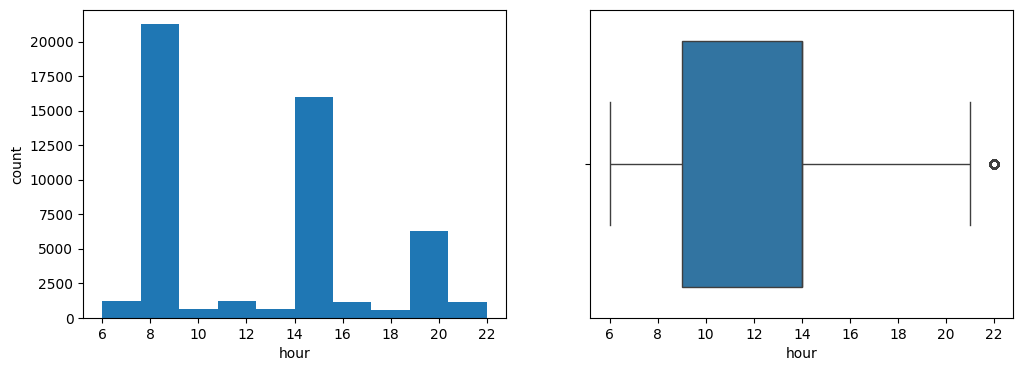

distance_km
Skew : 0.01


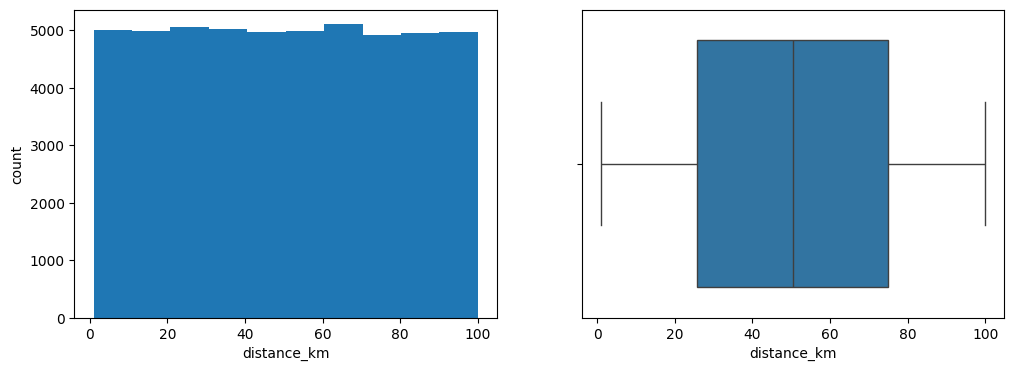

parcel_weight_kg
Skew : -0.0


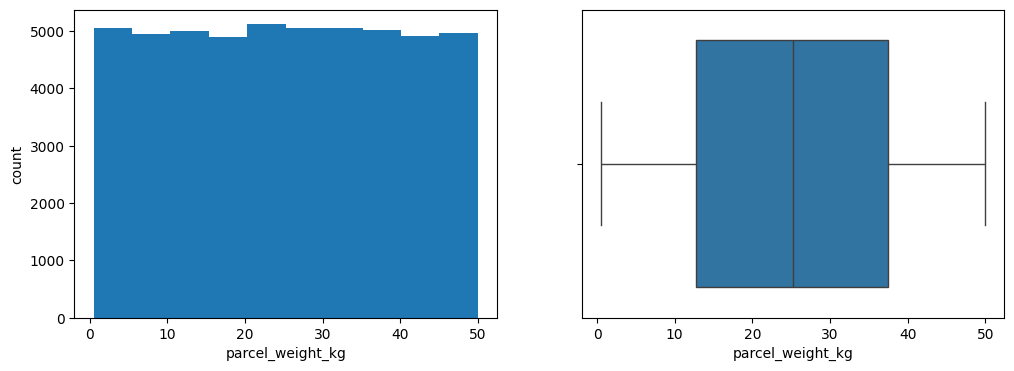

In [12]:
for col in num_cols:
    print(col)
    print('Skew :', round(delivery_data[col].skew(), 2))
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    delivery_data[col].hist(grid=False)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=delivery_data[col])
    plt.show()

As is evident from the plots, there is about an equal amount of examples for the distance_km and parcel_weight values. is_weekend is skewed to the 0 (week days), which makes sense as there are both more weekdays and more packages get send during the week. The expected delivery hour peaks at ~9, 15 and 19/20, with few packages being delivered after 18. 9 and 15 are the mean hours from the delivery windows, so it makes sense that those are the most prevalent times. Few packages get delivered in the evening.

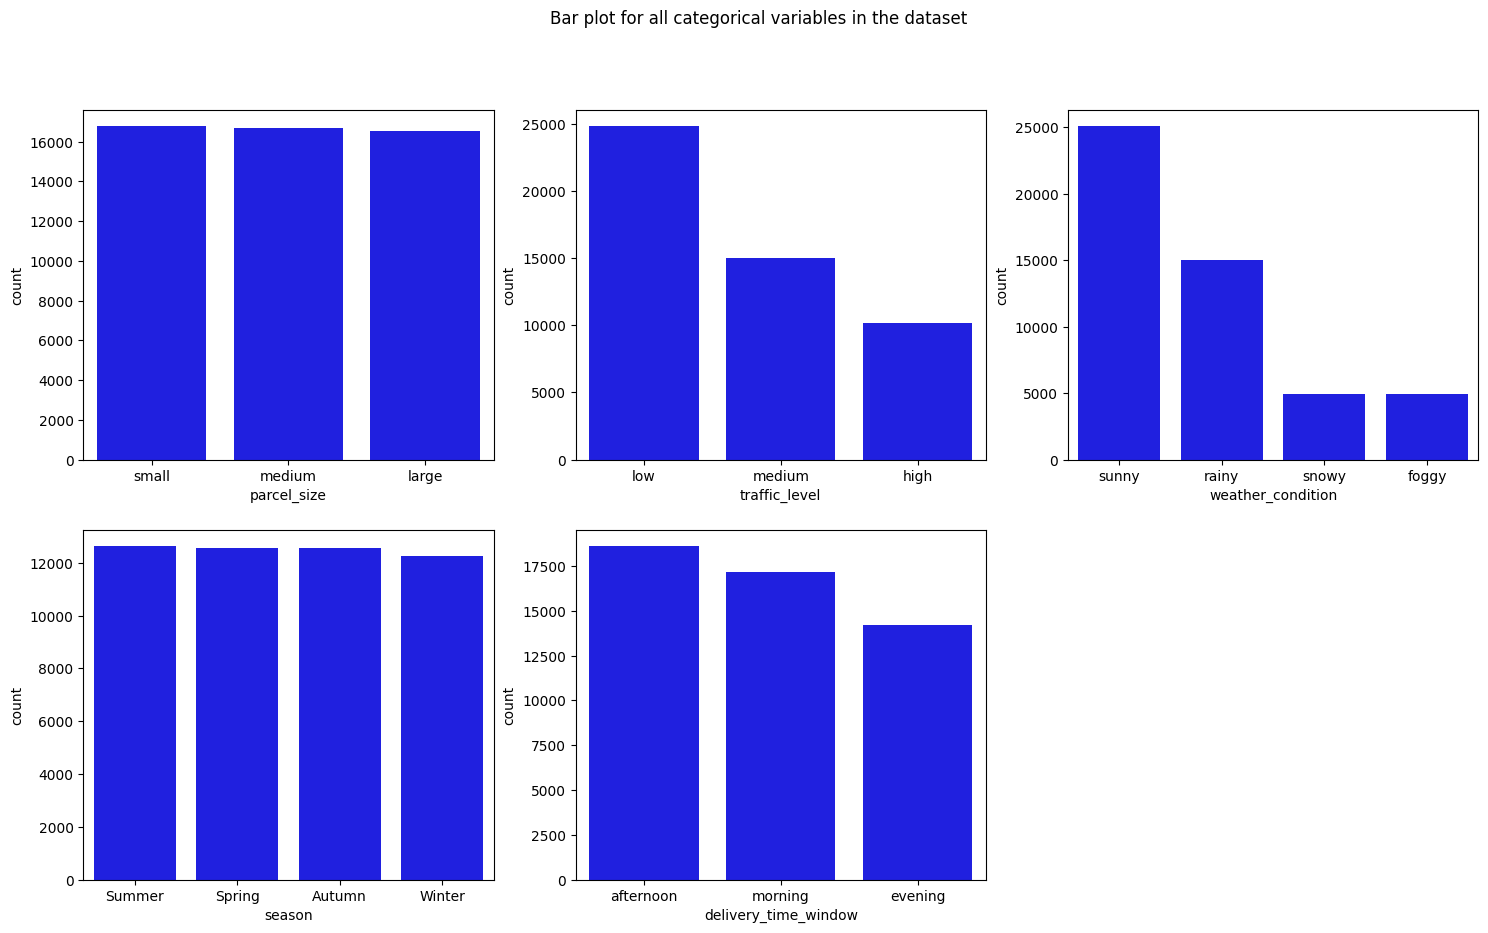

In [13]:
fig, axes = plt.subplots(2, 3, figsize = (18, 10))
axes[1][2].set_visible(False)
fig.suptitle('Bar plot for all categorical variables in the dataset')
for ax, col in zip(axes.ravel()[:-1], cat_cols):
    sns.countplot(ax = ax, x = col, data = delivery_data, color = 'blue', order = delivery_data[col].value_counts().index)
    ax.set_xlabel(col)


### Feature engineering and preparing data

In [93]:
def encode_and_split_data(data, cat_cols, y_col):

       one_hot_enc_X = preprocessing.OneHotEncoder(sparse_output=False)

       data_cat = data[cat_cols]

       X = data_cat.drop(y_col, axis = 1)
       
       cat_col_X = X.select_dtypes(include=['object']).columns

       y = data_cat[y_col]

       X = one_hot_enc_X.fit_transform(X)

       y = preprocessing.LabelBinarizer().fit_transform(y)

       one_hot_X = pd.DataFrame(X, columns = one_hot_enc_X.get_feature_names_out(cat_col_X))

       one_hot_X = pd.concat([data, one_hot_X], axis = 1)

       one_hot_X = one_hot_X.drop(cat_cols, axis = 1)

       return one_hot_X.values, y

encoded_delivery_data = encode_and_split_data(delivery_data, cat_cols, 'delivery_time_window')

X , y = encode_and_split_data(delivery_data, cat_cols,'delivery_time_window')


(50000, 18)

### Creating the neural network and training the model

In [164]:
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import accuracy_score
 
# Create the neural network
def get_model(n_inputs : int, n_outputs : int, optimizer : str = 'adam', activation : str = 'relu', dropout : float = 0.5):
   """This function generates a neural network using the keras library in Python.

   Args:
       n_inputs (int): The number of input features.
       n_outputs (int): The number of output features.
       optimizer (str, optional): The optimizer used by the compiler. Defaults to 'adam'.
       activation (str, optional): The activation function used by the layers in the neural network. Defaults to 'relu'.
       dropout (float, optional): The dropout probability of the dropout layer. Defaults to 0.5.

   Returns:
       model: Returns a neural network model with 4 layers, of which one dropout and one hidden layer. 
   """   
   model = Sequential()
   model.add(Input(shape=(18,)))
   model.add(Dense(18, kernel_initializer='he_uniform', activation=activation))
   model.add(Dense(16, activation=activation))
   model.add(Dropout(dropout))
   model.add(Dense(3, activation='sigmoid'))

   #compile the model
   model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
   return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, optimizer : str = 'adam', activation : str = 'relu', dropout : float = 0.1):
    """_summary_

    Args:
        X (numpy array): _description_
        y (numpy array): _description_
        optimizer (str, optional): _description_. Defaults to 'adam'.
        activation (str, optional): _description_. Defaults to 'relu'.
        dropout (float, optional): _description_. Defaults to 0.5.

    Returns:
        List of accuracy scores: The function returns a list of all accuracy scores obtained from the model training.
    """ 
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state = 1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs, optimizer, activation, dropout)
        # fit model, using a validation split
        model.fit(X_train, y_train, verbose=0, batch_size = 128, epochs=50, validation_split = 0.11)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        max = yhat.max(axis=1).reshape(-1, 1)

        res = np.where(yhat == max, 1, 0)
        # calculate accuracy
        acc = accuracy_score(y_test, res)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results
 
# # evaluate model
# results = evaluate_model(X, y, 'adam', 'relu', 0.1)
# # summarize performance
# print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

### Hyperparameter tuning

In [159]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = KerasClassifier(model=get_model, 
                        optimizer = 'adam', 
                        activation = 'relu', 
                        verbose=0,
                        n_inputs = 18,
                        n_outputs = 3, 
                        epochs=10, 
                        batch_size=32, 
                        dropout = 0.5)

# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'batch_size': [64, 128, 256],
    'epochs': [50, 80, 100],
    'dropout': [0.1, 0.2, 0.4, 0.5]
}

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, n_iter = 5, error_score='raise')
grid_result = grid.fit(X, y)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Accuracy: {grid_result.best_score_}")

Best Parameters: {'optimizer': 'adam', 'epochs': 100, 'dropout': 0.1, 'batch_size': 128, 'activation': 'relu'}
Best Accuracy: 0.6301400097043061


In [165]:
import shap

model = get_model(18, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)


model.fit()